In [213]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import bt
from bt.core import Algo
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import risk_matrix
import numpy as np
from datetime import datetime
from pandas_datareader import data as wb
import datetime as dt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [214]:
#main_tickers = ['FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE'] # ,'TMV.DE' #Data is imported from yahoo finance in the currency stated there
#main_tickers = ['VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] #US factor portfolio
#main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV'] #International factor portfolio 
main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] # US + International Factor portfolio 
#benchmark = ['EUMD.L'] # FS Invest portfolio 
#benchmark = ['SPY'] #US Factor portfolio 
benchmark = ['IWDA.AS'] #World Factor portfolio 
main_benchmark_tickers = ['IWDA.AS', 'IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV' ] #Factor portfolio 
#main_benchmark_tickers = ['EUMD.L', 'FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'KP5.F', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE','TMV.DE'] #FS invest portfolio
today = dt.date.today()
start_date_input = today - dt.timedelta(days=365*5) #importing data five years back 



In [215]:
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

plot_data = import_stock_data(tickers = main_benchmark_tickers, start = start_date_input).dropna()

data = import_stock_data(tickers = main_tickers, start = start_date_input).dropna()

data_benchmark = import_stock_data(tickers = benchmark, start = start_date_input).dropna() #Truncate data depending on the start of backtesting 


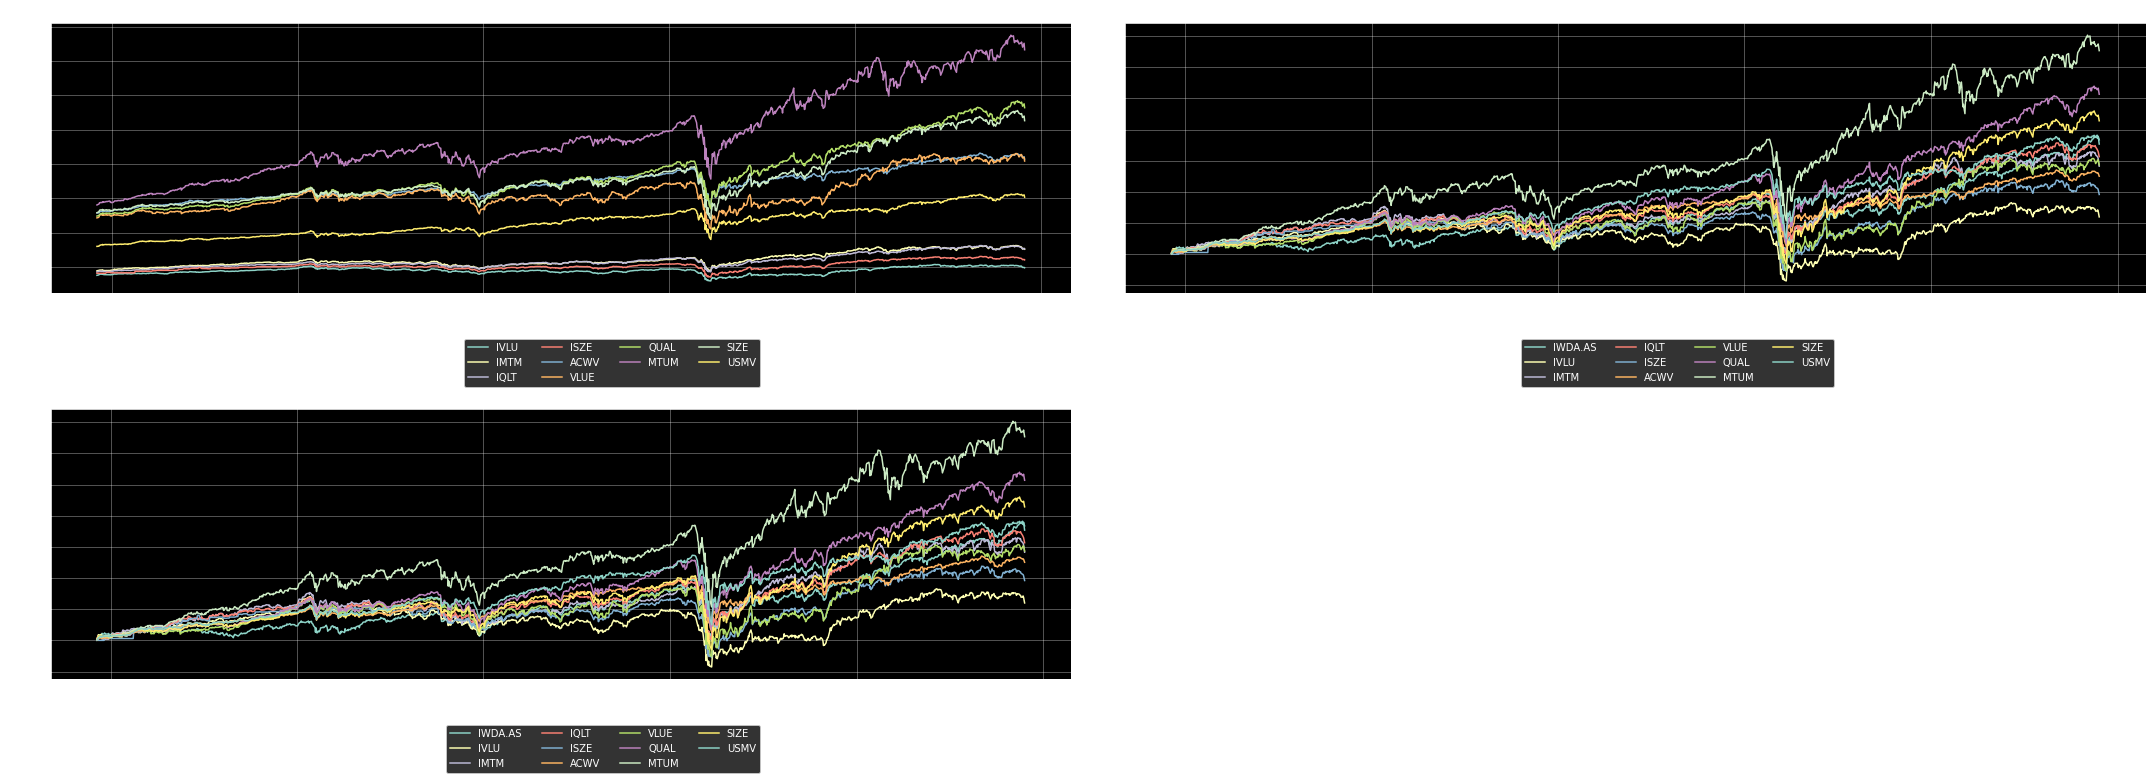

In [216]:
columns = data.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(data[col]) #Data plotted w/o the benchmark as it has to be scaled at times 
    plt.xlabel('Date')
    plt.ylabel('Security Price in Currency stated on Yahoo Finance')
    plt.title('Security Price development of the stocks within the portoflio - not scaled')
    plt.grid(alpha = 0.4)
    plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

columns = plot_data.columns
plt.subplot(3,2,2)
plt.plot((plot_data.pct_change() + 1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period ')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

#Removing outlier to see the returns better (if there are any)
plt.subplot(3,2,3)
plt.plot(((plot_data.loc[:, plot_data.columns!='KP5.F']).pct_change()+1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period w/o outliers')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

plt.tight_layout()

In [217]:
#creating the minimum volatility weight function to be used in the minvol algo
def calc_pypf_minvol_weights(prices):
    mu = mean_historical_return(prices, compounding= True)
    s  = risk_matrix(prices, method= "sample_cov")
    
    ef =  EfficientFrontier(mu, s)
    minvol_weights = ef.min_volatility()

    return minvol_weights

#create the weighminvol class to be used as an algo in the bt framework
class WeighMinVol(Algo):

    """
    Sets temp['weights'] based on minimum variance optimization.

    Sets the target weights based on calc_min_vol_weights.

    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
          each asset in the optimization.
        * covar_method (str): method used to estimate the covariance.
        * rf (float): risk-free rate used in optimization.

    Sets:
        * weights

    Requires:
        * selected
    """

    def __init__(
        self,
        lookback=pd.DateOffset(months=3),
        bounds=(0.0, 1.0),
        covar_method="ledoit-wolf",
        rf=0.0,
        lag=pd.DateOffset(days=0),
    ):
        super(WeighMinVol, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf

    def __call__(self, target):
        selected = target.temp["selected"]

        if len(selected) == 0:
            target.temp["weights"] = {}
            return True

        if len(selected) == 1:
            target.temp["weights"] = {selected[0]: 1.0}
            return True

        t0 = target.now - self.lag
        prc = target.universe.loc[t0 - self.lookback : t0, selected]
        tw = calc_pypf_minvol_weights(prc)

        target.temp["weights"] = tw
        return True

In [218]:
strategy_meanvar = bt.Strategy('Strategy Maximum Sharpe Ratio', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighMeanVar(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_minvol = bt.Strategy('Strategy Minimum Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    WeighMinVol(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_1n =  bt.Strategy('Strategy 1/N', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighEqually(),
                    bt.algos.Rebalance()])

strategy_invvol =  bt.Strategy('Strategy Inverse Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighInvVol(),
                    bt.algos.Rebalance()])

strategy_erc =  bt.Strategy('Equal Risk Contribution', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighERC(covar_method='standard', risk_parity_method='ccd', maximum_iterations = 10000),
                    bt.algos.Rebalance()])



In [219]:
#Markowitz portfolio
backtest_meanvar = bt.Backtest(strategy_meanvar, data)
result_meanvar   = bt.run(backtest_meanvar)

#Minimum Volatility
backtest_minvol = bt.Backtest(strategy_minvol, data)
result_minvol   = bt.run(backtest_minvol)

#1/N portfolio
backtest_1n = bt.Backtest(strategy_1n, data)
result_1n   = bt.run(backtest_1n)

#Inverse Volatility 
backtest_invvol = bt.Backtest(strategy_invvol, data)
result_invvol = bt.run(backtest_invvol)

#Equal Risk Contribution 
backtest_erc = bt.Backtest(strategy_erc, data)
result_erc = bt.run(backtest_erc)


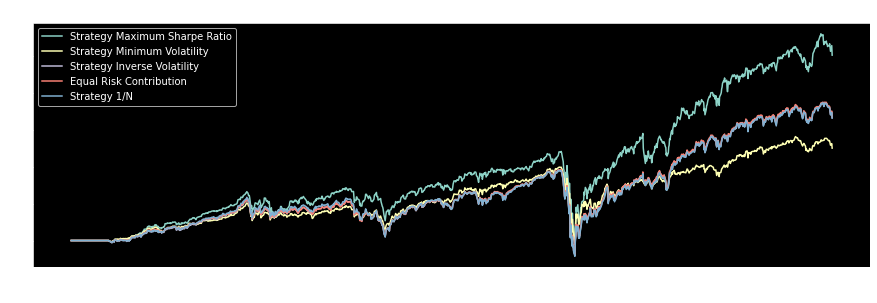

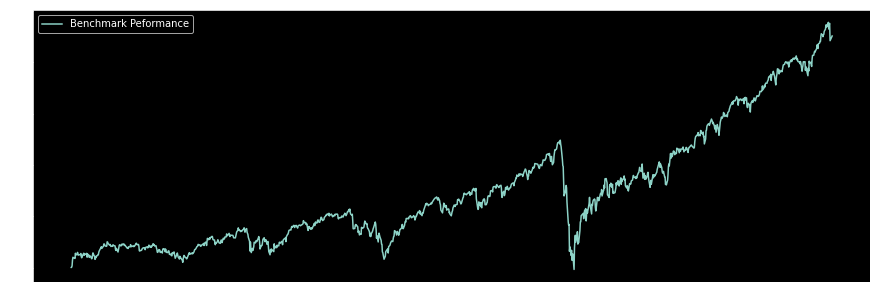

In [220]:
bt.run(backtest_meanvar, backtest_minvol, backtest_invvol, backtest_erc, backtest_1n).plot()

plt.figure(figsize=(15,5))
plt.plot((data_benchmark.pct_change()+1).cumprod()*100, label = 'Benchmark Peformance')
plt.legend()

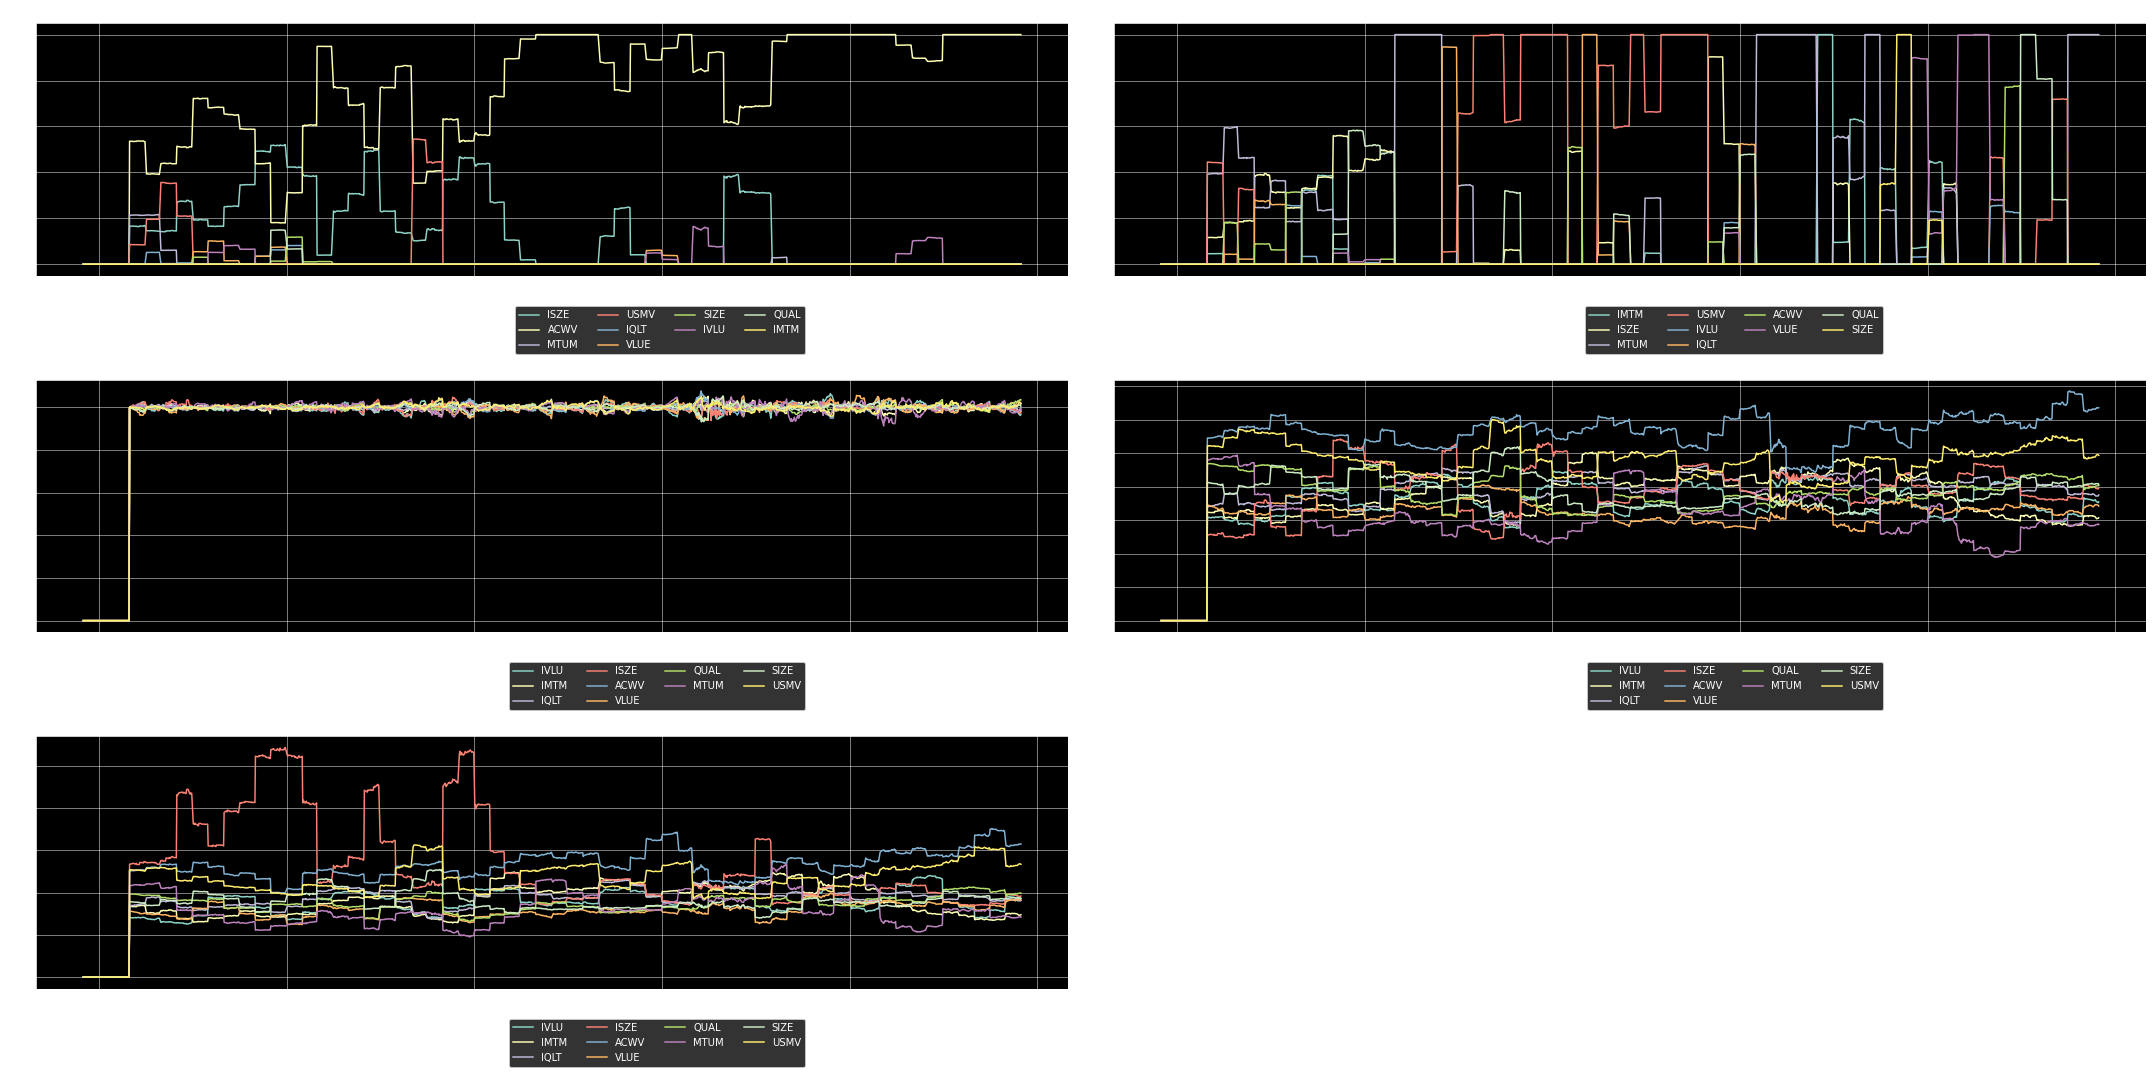

In [221]:
weights_meanvar = result_meanvar.get_security_weights()
weights_minvol = result_minvol.get_security_weights()
weights_1n = result_1n.get_security_weights()
weights_invvol = result_invvol.get_security_weights()
weights_erc = result_erc.get_security_weights()

#plotting the weights
fig, ax = plt.subplots(figsize=(30,15))

plt.subplot(3,2,1)
plt.plot(weights_minvol)
plt.title('MinVol Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_minvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,2)
plt.plot(weights_meanvar)
plt.title('MeanVar Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_meanvar.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,3)
plt.plot(weights_1n)
plt.title('1/N Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_1n.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,4)
plt.plot(weights_invvol)
plt.title('Inverse Volatility Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_invvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,5)
plt.plot(weights_erc)
plt.title('Equal Risk Contribution Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_erc.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.tight_layout()

In [222]:
def max_dd(total_r_series, days=250, minmin = True):
    """
    Maximum Draw-down during the last 12M
    """
    if minmin == True:
        roll_max = total_r_series.rolling(min_periods=1,window=days).max()

        daily_drawdown = total_r_series / roll_max - 1

        max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=days).min().min()

        return max_daily_drawdown
        
    else:
        roll_max = total_r_series.rolling(min_periods=1,window=days).max()

        daily_drawdown = total_r_series / roll_max - 1

        max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=days).min()

        return max_daily_drawdown

total_return_benchmark = (data_benchmark.pct_change()+1).cumprod().iloc[-1] - 1
std_benchmark = (data_benchmark.pct_change()).std() * np.sqrt((252))
mu_benchmark = mean_historical_return(data_benchmark, compounding= True)
sr_benchmark = mu_benchmark / std_benchmark
skew_benchmark = (data_benchmark.pct_change()).skew()
max_dd_benchmark = max_dd((data_benchmark.pct_change()+1).cumprod())
kurt_benchmark = (data_benchmark.pct_change()).kurt()

print("\nBenchmark's Total Return Factor: ", round(total_return_benchmark[-1],2), "\nBenchmark's Standard Deviation: ", round(std_benchmark[-1],4),
      "\nBenchmark's mean historical return: ", round(mu_benchmark[-1],4), "\nBenchmark's Sharpe Ratio", round(sr_benchmark[-1],2), 
      "\nBenchmark's return skewness", round(skew_benchmark[-1],4), "\nBencmark's maximum drawdown", round(max_dd_benchmark[-1],2), 
      "\nBenchmark's return kurtosis", round(kurt_benchmark[-1],4))


Benchmark's Total Return Factor:  0.9 
Benchmark's Standard Deviation:  0.1588 
Benchmark's mean historical return:  0.1356 
Benchmark's Sharpe Ratio 0.85 
Benchmark's return skewness -0.8077 
Bencmark's maximum drawdown -0.34 
Benchmark's return kurtosis 12.4848


In [223]:
results = pd.DataFrame()
results = pd.DataFrame(index = result_meanvar.stats.index)
results["Strategy MSR"] = result_meanvar.stats
results["Strategy MinVol"] = result_minvol.stats
results["Strategy InvVol"] = result_invvol.stats
results["Equal Risk Contribution"] = result_erc.stats
results["Strategy 1/N"] = result_1n.stats
results

,Strategy MSR,Strategy MinVol,Strategy InvVol,Equal Risk Contribution,Strategy 1/N
start,2016-12-01 00:00:00,2016-12-01 00:00:00,2016-12-01 00:00:00,2016-12-01 00:00:00,2016-12-01 00:00:00
end,2021-11-30 00:00:00,2021-11-30 00:00:00,2021-11-30 00:00:00,2021-11-30 00:00:00,2021-11-30 00:00:00
rf,0.0,0.0,0.0,0.0,0.0
total_return,1.007283,0.502121,0.666745,0.67338,0.665679
cagr,0.149643,0.084839,0.107654,0.108535,0.107512
max_drawdown,-0.340817,-0.2939,-0.33357,-0.333381,-0.33846
calmar,0.439073,0.288666,0.322734,0.325559,0.317652
mtd,-0.039488,-0.019389,-0.030288,-0.03022,-0.031217
three_month,-0.021359,-0.027757,-0.028473,-0.028631,-0.027216
six_month,0.038894,0.008494,0.006848,0.006425,0.006443


In [224]:
result_invvol.get_transactions().tail(10)

price  quantity
Date       Security                      
2021-11-01 ACWV      106.000000    -188.0
           IMTM       40.330002     282.0
           IQLT       40.070000      -8.0
           ISZE       32.145000     557.0
           IVLU       26.360001     905.0
           MTUM      192.639999      -8.0
           QUAL      141.610001    -121.0
           SIZE      136.270004      11.0
           USMV       77.459999    -294.0
           VLUE      104.480003      68.0

In [228]:
result_meanvar.get_security_weights().tail()

,IMTM,ISZE,MTUM,USMV,IVLU,IQLT,ACWV,VLUE,QUAL,SIZE
2021-11-23,0.0,0.0,0.999931,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-24,0.0,0.0,0.999931,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-26,0.0,0.0,0.999930,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-29,0.0,0.0,0.999931,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-30,0.0,0.0,0.999929,0.0,0.0,0.0,0.0,0.0,0.0,0.0
